<a href="https://colab.research.google.com/github/IlyaGalyukshev/colab/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [293]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.datasets import load_iris
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

**Линейная регрессия**

In [232]:
class MyLinearRegression:
  def __init__(self, fit_intercept=True):
    self.fit_intercept = fit_intercept

  def fit(self, X, y):
    n, k = X.shape
    X_trian = X
    if self.fit_intercept:
      X_train = np.hstack((X, np.ones((n, 1))))
    self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y
    return self

  def predict(self, X):
    n, k = X.shape
    X_train = X
    if self.fit_intercept:
      X_train = np.hstack((X, np.ones((n, 1))))
    preds = X_train @ self.w
    return preds

  def get_weights(self):
    return self.w

In [233]:
def linear_expression(x):
  return 4 * x + 3

In [234]:
cnt = 50
X = np.linspace(-5, 15, cnt)
y = linear_expression(X) + np.random.randn(cnt) * 10

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

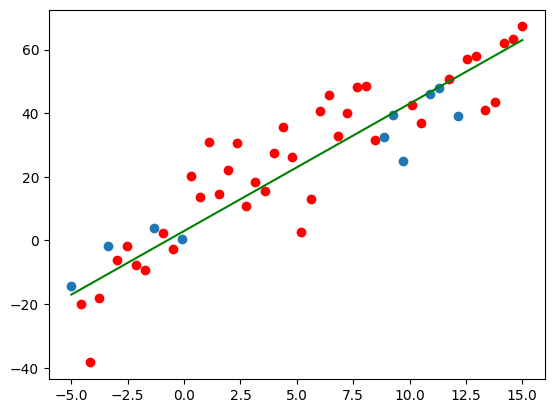

In [235]:
plt.scatter(X_train, y_train, c='r')
plt.scatter(X_test, y_test)
plt.plot(X, linear_expression(X), c='g')

In [236]:
model = MyLinearRegression()
model.fit(X_train.reshape(X_train.shape[0], 1), y_train)
preds = model.predict(X_test.reshape(X_test.shape[0], 1))
w = model.get_weights()

print(preds); print(w)

[ 4.81092081e+00 -1.45877059e+01 -8.12149700e+00  5.00743831e+01
  4.84578309e+01  4.03750698e+01 -3.87358696e-02  5.33074876e+01
  4.36081742e+01  4.19916220e+01]
[3.96055295 5.21505887]


**Линейная регрессия из sklearn**

In [237]:
sk_model = LinearRegression()
sk_model.fit(X_train.reshape(X_train.shape[0], 1), y_train)
sk_preds = sk_model.predict(X_test.reshape(X_test.shape[0], 1))

In [238]:
sk_preds - preds

array([-5.32907052e-15, -3.55271368e-15, -1.77635684e-15, -1.42108547e-14,
       -1.42108547e-14, -1.42108547e-14, -3.73312492e-15, -1.42108547e-14,
       -7.10542736e-15, -7.10542736e-15])

In [239]:
print(mean_squared_error(y_test, preds))
print(mean_squared_error(y_test, sk_preds))

70.86624675287338
70.86624675287325


**Линейная регрессия с градиентным спуском**

In [240]:
class MyGradientLinearRegression(MyLinearRegression):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.w = None

  def _calc_grad(self, X, y, y_pred):
    return (2 * (y_pred - y)[:, np.newaxis] * X).mean(axis=0)

  def get_losses(self):
    return self.losses

  def fit(self, X, y, lr=0.01, max_iter=100):
    n, k = X.shape
    if self.w is None:
      self.w = np.random.randn(k + 1 if self.fit_intercept else k)

    X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
    self.losses = []

    for iter in range(max_iter):
      y_pred = self.predict(X)
      self.losses.append(mean_squared_error(y_pred, y))
      grad = self._calc_grad(X_train, y, y_pred)
      self.w -= lr * grad
    return self

In [241]:
model1 = MyGradientLinearRegression()
model1.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()
preds1 = model1.predict(X_test[:, np.newaxis])

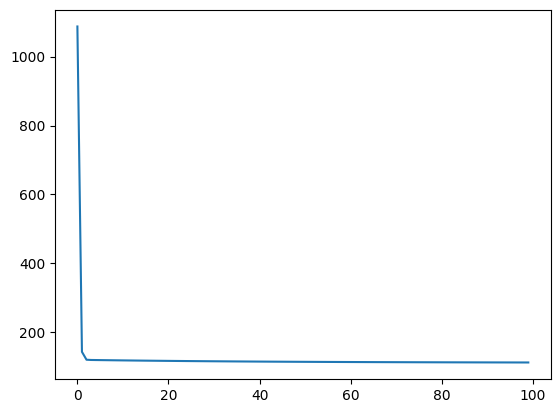

In [242]:
plt.plot(model1.get_losses())

**Линейная регрессия со стохастическим градиентным спуском**

In [243]:
class MySGDLinearRegression(MyGradientLinearRegression):
  def __init__(self, n_sample, **kwargs):
    super().__init__(**kwargs)
    self.w = None
    self.n_sample = n_sample

  def _calc_grad(self, X, y, y_pred):
    inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
    return (2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]).mean(axis=0)

In [244]:
model2 = MySGDLinearRegression(n_sample=10)
model2.fit(X_train[:, np.newaxis], y_train)
preds2 = model2.predict(X_test[:, np.newaxis])

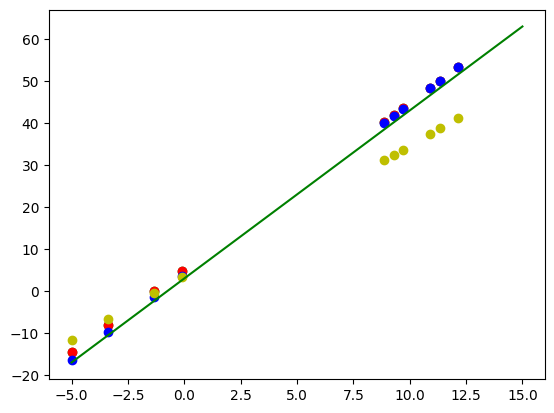

In [245]:
plt.scatter(X_test, preds, c='g')
plt.scatter(X_test, sk_preds, c='r')
plt.scatter(X_test, preds1, c='b')
plt.scatter(X_test, preds2, c='y')
plt.plot(X, linear_expression(X), c='g')

**Логистическая регрессия**

In [246]:
def logit(x, w):
  return np.dot(x, w)

def sigmoid(h):
  return 1. / (1 + np.exp(-h))

class MyLogisticRegression(object):
  def __init__(self):
    self.w = None

  def __loss(self, y, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return np.mean(y_pred * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

  def get_weights(self):
    return self.w

  def fit(self, X, y, max_iter=100, lr=0.1):
    n, k = X.shape
    if self.w is None:
      self.w = np.random.randn(k + 1)
    X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
    losses = []
    for iter in range(max_iter):
      z = sigmoid(logit(X_train, self.w))
      grad = np.dot(X_train.T, (z - y)) / len(y)
      self.w -= grad * lr
      losses.append(self.__loss(y, z))
    return losses

  def predict_proba(self, X):
    n, k = X.shape
    X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
    return sigmoid(logit(X_, self.w))

  def predict(self, X, threshold=0.5):
    return self.predict_proba(X) > threshold

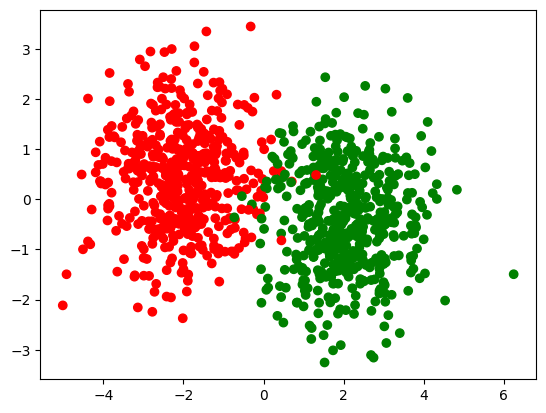

In [247]:
X, y = make_blobs(n_samples=1000, centers=((-2, 0.5), (2, -0.5)), cluster_std=1)

colors = ('red', 'green')
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate((0, 1)):
  colored_y[y == cl] = str(colors[i])

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

In [248]:
log_reg = MyLogisticRegression()
log_reg.fit(X, y, max_iter=1000)
w = log_reg.get_weights()

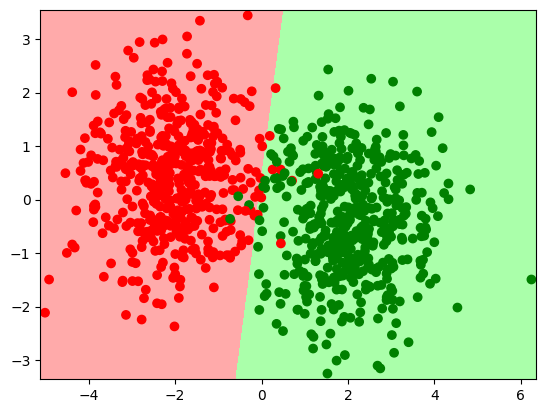

In [249]:
eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=colored_y)

**Ridge (L2-регуляризация)**

In [250]:
cnt = 100
X = np.linspace(-10, 10, cnt)
y = linear_expression(X) + np.random.randn(cnt) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [253]:
reg = Ridge(alpha=1).fit(np.hstack((X, X, X))[:, np.newaxis], np.hstack((y, y, y)))
np.append(reg.coef_, reg.intercept_)

array([3.96191464, 2.4193788 ])

In [255]:
reg = Ridge(alpha=1/3).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([3.96191464, 2.4193788 ])

In [259]:
class MyRidgeRegression(MyLinearRegression):
  def __init__(self, alpha=1, **kwargs):
    super().__init__(**kwargs)
    self.alpha = alpha

  def get_weights(self):
    return self.w

  def fit(self, X, y):
    n, m = X.shape
    X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
    lambdaI = self.alpha * np.eye(X_train.shape[1])
    if self.fit_intercept:
      lambdaI[-1, -1] = 0

    self.w = np.linalg.inv(X_train.T @ X_train + lambdaI) @ X_train.T @ y
    return self

In [262]:
regressor = MyRidgeRegression(alpha=1).fit(X_train[:, np.newaxis], y_train)
sk_regressor = Ridge(alpha=1).fit(X_train[:, np.newaxis], y_train)

In [263]:
print(np.append(sk_regressor.coef_, sk_regressor.intercept_))
print(regressor.get_weights())

[3.97427226 2.07547564]
[3.97427226 2.07547564]


In [264]:
preds3 = regressor.predict(X_test[:, np.newaxis])

In [270]:
class MySGDRidge(MySGDLinearRegression):
  def __init__(self, alpha=1, **kwargs):
    super().__init__(**kwargs)
    self.w = None
    self.alpha = alpha

  def _calc_grad(self, X, y, y_pred):
    inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
    lambdaI = self.alpha * np.eye(self.w.shape[0])
    if self.fit_intercept:
      lambdaI[-1, -1] = 0
    grad = 2 * (X[inds].T @ X[inds] / self.n_sample + lambdaI) @ self.w
    grad -= 2 * X[inds].T @ y[inds] / self.n_sample
    return grad

In [271]:
model4 = MySGDRidge(alpha=1, n_sample=10)
model4.fit(X_train[:, np.newaxis], y_train)
preds4 = model4.predict(X_test[:, np.newaxis])

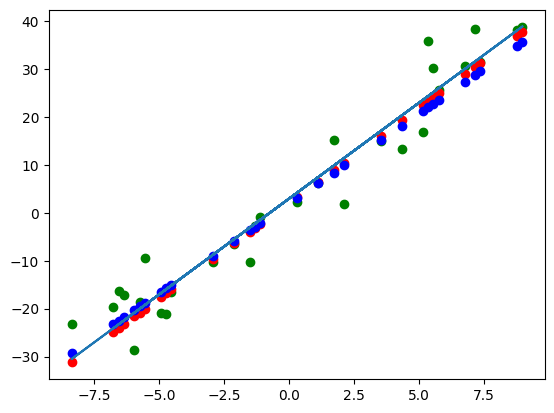

In [272]:
plt.scatter(X_test, y_test, c='g')
plt.scatter(X_test, preds3, c='r')
plt.scatter(X_test, preds4, c='b')
plt.plot(X_test, linear_expression(X_test))

**Lasso (L1-регуляризация)**

In [275]:
lasso = Lasso(alpha=1).fit(np.hstack((X, X, X))[:, np.newaxis], np.hstack((y, y, y)))
np.append(lasso.coef_, lasso.intercept_)

array([3.93289705, 2.4193788 ])

In [276]:
lasso = Lasso(alpha=1).fit(X[:, np.newaxis], y)
np.append(lasso.coef_, lasso.intercept_)

array([3.93289705, 2.4193788 ])

In [278]:
def soft_sign(x, eps=1e-7):
  if abs(x) > eps:
    return np.sign(x)
  return x / eps

np_soft_sign = np.vectorize(soft_sign)

class MySGDLasso(MySGDLinearRegression):
  def __init__(self, alpha=1, **kwargs):
    super().__init__(**kwargs)
    self.w = None
    self.alpha = alpha

  def _calc_grad(self, X, y, y_pred):
    inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)
    signw = np_soft_sign(self.w)
    if self.fit_intercept:
      signw[-1] = 0
    grad = X[inds].T @ (y_pred[inds] - y[inds])[:, np.newaxis] / self.n_sample
    grad += self.alpha * signw[:, np.newaxis]
    return grad.flatten()

In [280]:
lasso = MySGDLasso(alpha=1, n_sample=4).fit(X[:, np.newaxis], y)
lasso.get_weights()

array([4.01621603, 2.15032866])

In [281]:
sk_lasso = Lasso().fit(X[:, np.newaxis], y)
np.append(sk_lasso.coef_, sk_lasso.intercept_)

array([3.93289705, 2.4193788 ])

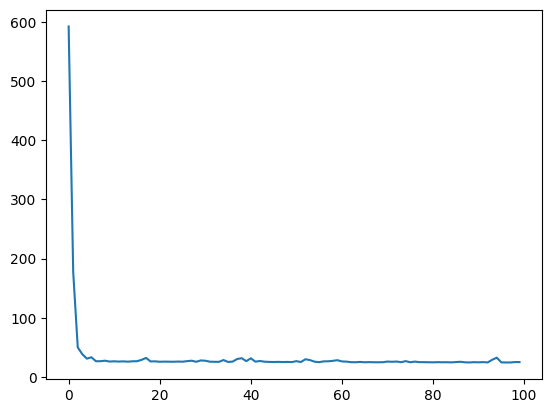

In [282]:
plt.plot(lasso.get_losses())

**Ирисы**

In [286]:
iris = load_iris()
data = pd.DataFrame(data=np.hstack([iris.data, iris.target[:, np.newaxis]]),
                    columns=iris.feature_names + ['target'])
features = data.columns
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


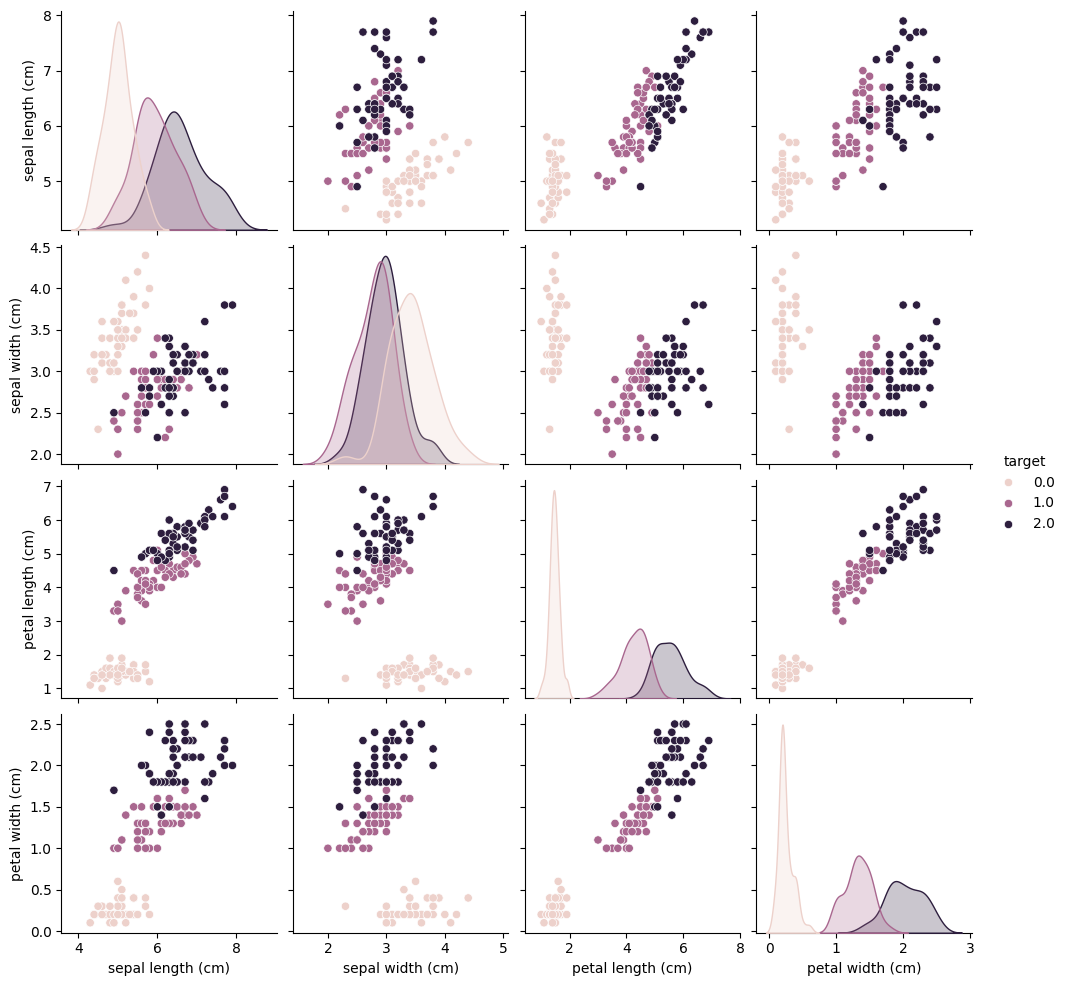

In [288]:
sns.pairplot(data, hue='target')

In [291]:
X_train, X_test, y_train, y_test = train_test_split(data[features[:-1]], data[features[-1]], train_size=0.7)

In [306]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(C=2))
pipeline = pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_train)
np.append(accuracy_score(preds, y_train), f1_score(preds, y_train, average='macro'))

array([0.97142857, 0.97061954])

In [307]:
test_preds = pipeline.predict(X_test)
np.append(accuracy_score(test_preds, y_test), f1_score(test_preds, y_test, average='macro'))

array([0.97777778, 0.97765766])